# Это линейная регрессия с регуляризацией

Мы уже успели реализовать линейную регрессию на лекции 

 $Linear\quad Regression = \langle x , w \rangle $

Оптимизировали же мы нашу модель, уменьшая евклидово расстояние между примерами и предсказаниями нашей модели : $MSE= \sum_i(y_i-x_i^Tw)^2=||Y-Xw||_2^2$
Однако так модель может найти "идеальные" или около того параметры на тренировочных данных, однако тренировочные данные не позволяют модели обобщиться, а значит не позволяют добиться того, чего мы хочем.
Чтобы модель не "подгонялась" под тренировочные данные люди решили добавлять в функцию потерь штраф за большие веса(статистически доказано, что переобучение связано с высокими весами). Методы, назначенные на борьбу с переобучением моделей называются регуляризацией.
Собственно говоря, здесь я реализовал один из способов - ridge-regression.

В гребневой регрессии мы штрафуем модель также на сумму квадратов ее весов, таким образом:

$Cost:L(w) = ||Xw - Y||^2_2 + \lambda||w||^2_2$, где $\lambda$ - гиперпараметр, т.е. задается до начала обучения.

Значения признаков должны быть стандартизированы для одинаковых штрафов относительо друг друга.
Ниже я реализовал обычную линейную регрессию с градиентной оптимизацией.

In [4]:
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.w = None
        self.n_sample = n_sample
    def fit(self, X, y, lr=0.01, max_iter=100):
      
        n, k = X.shape

        if self.w is None:
            self.w = np.random.randn(k + 1 if self.fit_intercept else k)
        
        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X
        
        self.losses = []
        
        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(mean_squared_error(y_pred, y))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape == self.w.shape, f"gradient shape {grad.shape} is not equal weight shape {self.w.shape}"
            self.w -= lr * grad

        return self
        
    def predict(self, X):
        n, k = X.shape
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        y_pred = X_train @ self.w

        return y_pred
    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)
        
        grad = 2 * (y_pred[inds] - y[inds])[:, np.newaxis] * X[inds]
        grad = grad.mean(axis=0)

        return grad

    def get_losses(self):
        return self.losses
    

In [7]:
from sklearn.model_selection import train_test_split
def linear_expression(x):
    return 5 * x + 6
objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

Для градиентной оптимизации нужно рассчитать значение градиента $\displaystyle\frac{\partial{L}}{\partial{w}}$ : $$ L(w) = ||Xw - Y||^2_2 + ||\Gamma w||^2_2 $$

$$
\begin{aligned}L(w) &= ||Xw - Y||^2_2 + ||\Gamma w||^2_2
= (Xw - Y)^T(Xw - Y) + w^T\Gamma^T\Gamma w = \\
&= w^TX^TXw - 2Y^TXw + Y^TY + w^T\Gamma^T\Gamma w =
w^T(X^TX + \Gamma^T\Gamma)w - 2Y^TXw + Y^TY
\end{aligned}
$$

В нашем случае $\Gamma^T\Gamma = \lambda I$, если нет свободного члена, иначе:
$\Gamma^T\Gamma =
\left(\begin{matrix}
\lambda I & 0 \\
0 & 0
\end{matrix}\right)$

**Градиент:**
$$
\frac{\partial{L}}{\partial{w}}
= 2(X^TX + \Gamma^T\Gamma)w - 2X^TY
$$
Реализована модель стохастического градиентного спуска, потому мы будем усреднять ошибку по батчу данных $-> \quad делить \quad на \quad \frac{1}{n_{sample}}$

In [13]:
from sklearn.metrics import mean_squared_error
class MySGDRidge(MyLinearRegression):
    def __init__(self, alpha=1.0,n_sample=10,  **kwargs):
        super().__init__(**kwargs) # передает родительские параметры __init__
        self.w = None
        self.alpha = alpha
        self.n_sample=n_sample

    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        lambdaI = self.alpha * np.eye(self.w.shape[0])
        if self.fit_intercept:
            lambdaI[-1, -1] = 0

        grad = 2 * (X[inds].T @ X[inds] / self.n_sample + lambdaI) @ self.w
        grad -= 2 * X[inds].T @ y[inds] / self.n_sample

        return grad
    def get_weights(self):
        return self.w

Давайте сравним ответы нашей модели с заданой функцией linear_expression

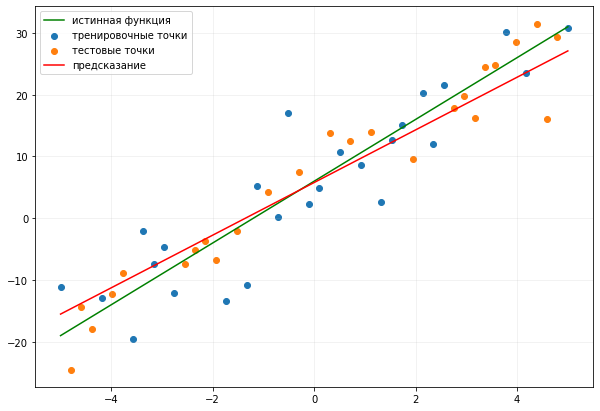

In [18]:
model = MySGDRidge(alpha=1,n_sample=20)
model.fit(X[:,np.newaxis], y , max_iter=1000,lr=0.01)
weights = model.get_weights()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='истинная функция', c='g')

plt.scatter(X_train, y_train, label='тренировочные точки')
plt.scatter(X_test, y_test, label='тестовые точки')
plt.plot(X, model.predict(X[:, np.newaxis]), label='предсказание', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()


Сравним нашу модель с моделью, реализованной в sklearn

In [23]:
sklearn_reg=Ridge(1.0)
sklearn_reg.fit(X[:,np.newaxis], y)
list1=[]
list1.append(sklearn_reg.coef_)
list1.append(sklearn_reg.intercept_)
print(*list1)
print(weights)

[4.76806237] 5.823870900664518
[4.26061988 5.78618938]


# Неплохо!